In [ ]:
%pip install pandas matplotlib cartopy numpy gstlearn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
# Charger les données
file_path = "data/pdh_data.parquet"
data = pd.read_parquet(file_path)
print(data)
# Supprimer les colonnes qui n'ont pas 'pfas_values' dans leur nom
columns_to_keep = ['lon', 'lat','date','pfas_sum']  # Garder longitude et latitude pour le filtrage des localisations
data_filtered = data[columns_to_keep]
data_filtered = data_filtered.dropna(subset=['pfas_sum'])
data_filtered = data_filtered.dropna(subset=['date'])

# Nettoyer la colonne 'date' pour ne garder que la partie date (suppression de l'heure et du fuseau horaire)
data_filtered['date_clean'] = data_filtered['date'].str.split(' ').str[0]
# Convertir la colonne 'date_clean' en format datetime
data_filtered['date_column'] = pd.to_datetime(data_filtered['date_clean'], errors='coerce', format='%Y-%m-%d')

data_filtered.drop(columns=["date_clean","date"])

               category        lat       lon  \
0       Known PFAS user  52.504114 -0.682637   
1       Known PFAS user  50.871865  6.034522   
2       Known PFAS user  50.223409  8.765597   
3       Known PFAS user  47.858601  5.347156   
4       Known PFAS user  39.471674 -0.538828   
...                 ...        ...       ...   
478045            Known  52.245160  7.337400   
478046            Known  51.940830  8.045450   
478047            Known  51.060010  7.027150   
478048            Known  51.025880  8.145160   
478049            Known  51.657850  8.408000   

                                       name          city         country  \
0                                        3F         Corby  United Kingdom   
1                                        3M      Kerkrade     Netherlands   
2        3P - Performance Plastics Products        Karben         Germany   
3          3P Performance Plastics Products       Langres          France   
4       3P Productos Plásticos Perform

,lon,lat,pfas_sum,date_column
13000,17.283800,48.029770,8.50,2019-07-18
13001,19.885714,45.258514,7.20,2019-07-22
13002,25.914750,43.881083,201.70,2019-07-10
13003,19.123680,47.728225,13.10,2019-07-10
13004,18.749972,45.866695,28.90,2019-07-08
...,...,...,...,...
478045,7.337400,52.245160,9.94,2024-04-23
478046,8.045450,51.940830,0.00,2017-11-16
478047,7.027150,51.060010,93.00,2022-02-16
478048,8.145160,51.025880,0.00,2017-08-15


In [3]:
data_filtered.shape

(454026, 6)

In [4]:
data_filtered.dtypes

lon                   float64
lat                   float64
date                   object
pfas_sum              float64
date_clean             object
date_column    datetime64[ns]
dtype: object

In [5]:
data_filtered.head()

,lon,lat,date,pfas_sum,date_clean,date_column
13000,17.283800,48.029770,2019-07-18,8.5,2019-07-18,2019-07-18
13001,19.885714,45.258514,2019-07-22,7.2,2019-07-22,2019-07-22
13002,25.914750,43.881083,2019-07-10,201.7,2019-07-10,2019-07-10
13003,19.123680,47.728225,2019-07-10,13.1,2019-07-10,2019-07-10
13004,18.749972,45.866695,2019-07-08,28.9,2019-07-08,2019-07-08


In [7]:
data_2024 = data_filtered[data_filtered['date_column'].dt.year == 2019]

In [8]:
data_2024.shape

(36650, 6)

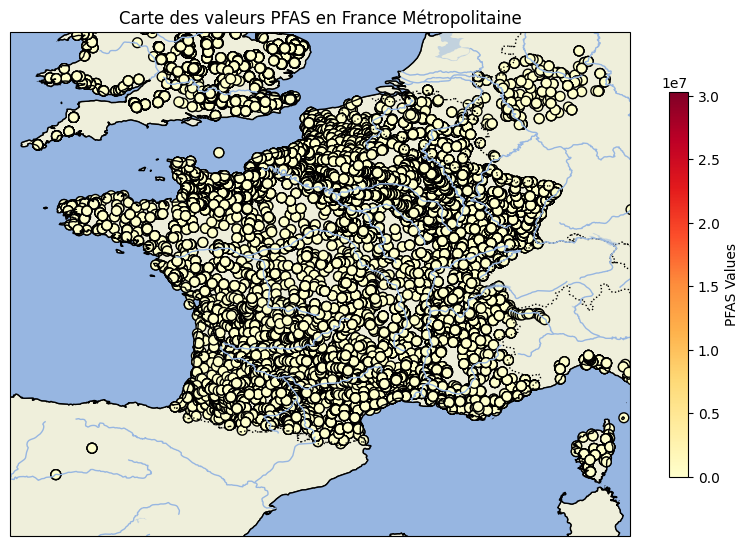

In [9]:
# Créer une figure et une projection Cartopy
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  # Utilise PlateCarree pour une projection simple

# Ajouter des éléments de base à la carte
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Créer une échelle de couleurs pour les valeurs PFAS
# Utilisation de `ax.scatter` avec `transform=ccrs.PlateCarree()` pour bien placer les points
sc = ax.scatter(data_2024['lon'], data_2024['lat'], c=data_2024['pfas_sum'], cmap='YlOrRd', edgecolor='k', s=50, transform=ccrs.PlateCarree())

# Ajouter une barre de couleur
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('PFAS Values')

# Définir les limites de la carte sur la France métropolitaine
ax.set_extent([-6, 10, 40, 53], crs=ccrs.PlateCarree())

# Ajouter un titre et afficher la carte
plt.title('Carte des valeurs PFAS en France Métropolitaine')
plt.show()

In [10]:
import gstlearn
print(dir(gstlearn))

['AAnam', 'AArray', 'ABiTargetCheck', 'ACalcDbToDb', 'ACalcDbVarCreator', 'ACalcInterpolator', 'ACalcSimulation', 'ACalculator', 'ACov', 'ACovAnisoList', 'ACovFunc', 'ACovGradient', 'ADrift', 'AEnum', 'AFunction', 'AFunctional', 'AGibbs', 'ALinearOp', 'ALinearOpMulti', 'AMatrix', 'AMatrixDense', 'AMatrixSquare', 'AMesh', 'ANeigh', 'ANoStat', 'AOF', 'APolynomial', 'ASCII_TEST', 'ASerializable', 'AShape', 'ASimulable', 'ASpace', 'ASpaceObject', 'ASpaceShape', 'AStringFormat', 'AStringable', 'AVario', 'AnamContinuous', 'AnamContinuousFit', 'AnamDiscrete', 'AnamDiscreteDD', 'AnamDiscreteIR', 'AnamEmpirical', 'AnamHermite', 'AnamUser', 'Array', 'BImage', 'BImageStringFormat', 'BUFFER_LENGTH', 'Ball', 'BiTargetCheckBench', 'BiTargetCheckCell', 'BiTargetCheckCode', 'BiTargetCheckDate', 'BiTargetCheckDistance', 'BiTargetCheckFaults', 'BiTargetCheckGeometry', 'BooleanObject', 'CGParam', 'CSVformat', 'CTable', 'CTables', 'CalcAnamTransform', 'CalcGlobal', 'CalcGridToGrid', 'CalcImage', 'CalcKrig

In [11]:
help(gstlearn.Db)

Help on class Db in module gstlearn:

class Db(AStringable, ASerializable, ICloneable)
 |  Db(*args)
 |
 |  Method resolution order:
 |      Db
 |      AStringable
 |      ASerializable
 |      ICloneable
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __getitem__ = getdbitem(self, arg) from gstlearn
 |      Extract data from a Db. Use Db[arg]
 |
 |      Parameters
 |      ----------
 |      arg is (rows, columns) or columns
 |      rows : (optional) int, list of int, or slice. Which rows (samples) to extract.
 |      columns: str or list of str. Names of the variables to extract.
 |               int, list of int, or slice. Indices of the variables to extract.
 |               gstlearn.ELoc. Locator of the variables to extract.
 |
 |      Returns
 |      -------
 |      numpy.ndarray
 |          2D array of shape (nrows, nvars) of the extracted data.
 |      Examples
 |      --------
 |      db["var"] or db[:,"var"] extracts the variable named "var"
 |      db[5:10,(2,3)] 

In [6]:
# Charger les données
file_path = "data/pdh_data.parquet"
data = pd.read_parquet(file_path)

# Supprimer les colonnes qui n'ont pas 'pfas_values' dans leur nom
columns_to_keep = ['lon', 'lat', 'date', 'pfas_sum', 'country']  # Garder la colonne 'country' pour filtrer la France
data_filtered = data[columns_to_keep]

# Filtrer uniquement les données de la France
data_france = data_filtered[data_filtered['country'] == 'France']

# Supprimer les lignes avec des valeurs manquantes dans 'pfas_sum' ou 'date'
data_france = data_france.dropna(subset=['pfas_sum', 'date'])

# Nettoyer la colonne 'date' pour ne garder que la partie date (suppression de l'heure et du fuseau horaire)
data_france['date_clean'] = data_france['date'].str.split(' ').str[0]

# Convertir la colonne 'date_clean' en format datetime
data_france['date_column'] = pd.to_datetime(data_france['date_clean'], errors='coerce', format='%Y-%m-%d')

# Supprimer les colonnes temporaires
data_france = data_france.drop(columns=["date_clean", "date", 'country'])

# Afficher les premières lignes des données filtrées pour la France
print(data_france.head())


             lon        lat  pfas_sum date_column
159212  1.765432  50.934294       0.0  2014-05-27
159213  1.765432  50.934294       0.0  2014-11-21
159214  1.765432  50.934294       0.0  2018-01-15
159215  1.765432  50.934294       0.0  2018-04-18
159216  1.765432  50.934294       0.0  2018-07-19


In [7]:
data_france_2024 = data_france[data_france['date_column'].dt.year == 2024]

In [8]:
import gstlearn as gl

db_france_2024 = gl.Db_fromPanda(data_france_2024)
db_france_2024


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 0
Number of Columns            = 3
Total number of samples      = 5952

Variables
---------
Column = 0 - Name = lon - Locator = NA
Column = 1 - Name = lat - Locator = NA
Column = 2 - Name = pfas_sum - Locator = NA

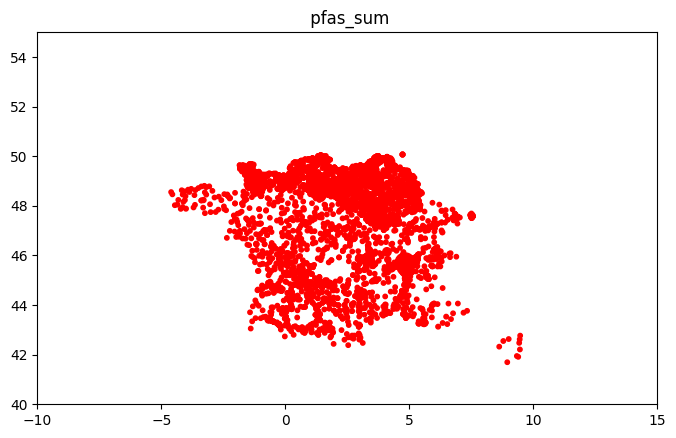

In [10]:
import gstlearn.plot as gp
fig, ax = gp.initGeographic()
ax.symbol(db_france_2024, nameCoorX='lon', nameCoorY='lat')
# Ajuster l'échelle des axes
plt.xlim(-10, 15)  # Limites pour l'axe des X
plt.ylim(40, 55)   # Limites pour l'axe des Y

plt.show()

In [11]:
db_france_2024.setLocators(["lon","lat"], gl.ELoc.X)
db_france_2024.setLocator("pfas_sum", gl.ELoc.Z)
db_france_2024


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 5952

Variables
---------
Column = 0 - Name = lon - Locator = x1
Column = 1 - Name = lat - Locator = x2
Column = 2 - Name = pfas_sum - Locator = z1


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         = 166335.295
Exponential
- Sill         =  94681.726
- Range        =      0.157
- Theo. Range  =      0.052
Total Sill     = 261017.021
Known Mean(s)     0.000


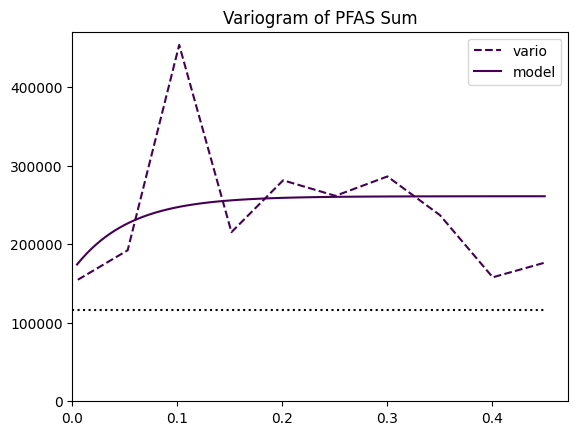

In [15]:
# Localiser la variable Z (pfas_sum)
db_france_2024.clearLocators(gl.ELoc.Z)
db_france_2024.setLocator("pfas_sum", gl.ELoc.Z)

# Définir les paramètres du variogramme (omnidirectionnel)
varioParam = gl.VarioParam.createOmniDirection(npas=10, dpas=0.05)

# Calculer le variogramme à partir des données
var_Z = gl.Vario.computeFromDb(varioParam, db_france_2024)

# Créer et ajuster un modèle au variogramme
mod_Z = gl.Model()
opt = gl.Option_AutoFit()
opt.setWmode(2)  # pondération proportionnelle au nombre de paires et inversement proportionnelle à la distance
mod_Z.fit(var_Z, [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.EXPONENTIAL], mauto=opt)

# Tracer le variogramme et le modèle ajusté
fig, ax = plt.subplots()
ax = gp.varmod(var_Z, mod_Z, flagLegend=True)
ax.decoration(title="Variogram of PFAS Sum")

# Afficher le modèle ajusté
mod_Z.display()

# Afficher le plot
plt.show()

In [30]:
help(gl.DisjunctiveKriging)

Help on function DisjunctiveKriging in module gstlearn:

DisjunctiveKriging(*args, **kwargs)




Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         = 163466.833
Total Sill     = 163466.833
Known Mean(s)     0.000


AttributeError: module 'gstlearn' has no attribute 'AnamDiscreteFit'

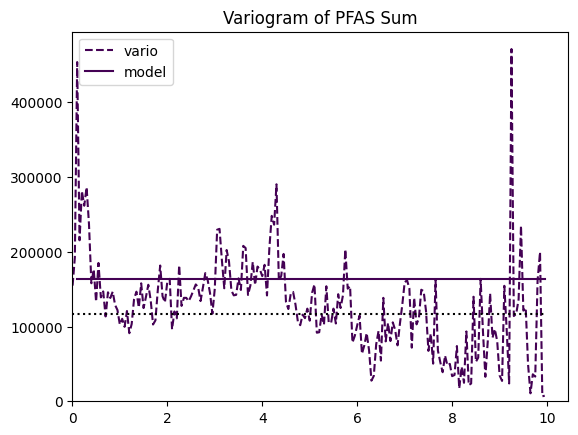

In [55]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Localize the variable Z (which is "pfas_sum")
db_france_2024.clearLocators(gl.ELoc.Z)
db_france_2024.setLocator("pfas_sum", gl.ELoc.Z)

# Step 2: Define the variogram parameters (omnidirectional in this case)
varioParam = gl.VarioParam.createOmniDirection(npas=200, dpas=0.05)

# Step 3: Compute the variogram from the data
var_Z = gl.Vario.computeFromDb(varioParam, db_france_2024)

# Step 4: Create and fit a model to the variogram
mod_Z = gl.Model()
opt = gl.Option_AutoFit()
opt.setWmode(2)  # Weighting mode: proportional to number of pairs and inversely proportional to distance
mod_Z.fit(var_Z, [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.EXPONENTIAL], mauto=opt)

# Step 5: Plot the variogram and the fitted model
fig, ax = plt.subplots()
ax = gp.varmod(var_Z, mod_Z, flagLegend=True)
ax.decoration(title="Variogram of PFAS Sum")
mod_Z.display()

# Step 6: Define the anamorphosis model for disjunctive kriging using AnamDiscreteFit
anam_model = gl.AnamDiscreteFit.create(db_france_2024, "pfas_sum")

# Step 7: Create a grid for interpolation
grid_lon = np.linspace(db_france_2024["lon"].min(), db_france_2024["lon"].max(), 50)
grid_lat = np.linspace(db_france_2024["lat"].min(), db_france_2024["lat"].max(), 50)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)
grid_coords = np.column_stack([grid_lon.ravel(), grid_lat.ravel()])

# Step 8: Perform Disjunctive Kriging using the Db object and anamorphosis model
dk = gl.DisjunctiveKriging(db_france_2024, anam_model, mod_Z, name_est='estimation_PFAS', name_std='std_PFAS')

# Step 9: Perform kriging on the grid
z_pred, z_std = dk.execute('grid', grid_lon, grid_lat)

# Reshape the predicted values to match the grid
z_pred = z_pred.reshape(grid_lon.shape)

# Step 10: Plot the kriging result
plt.figure(figsize=(10, 10))
plt.contourf(grid_lon, grid_lat, z_pred, cmap='YlOrRd')
plt.colorbar(label='Predicted PFAS Sum')
plt.scatter(db_france_2024["lon"], db_france_2024["lat"], c='black', s=10, label='Sample Points')
plt.title('Disjunctive Kriging of PFAS Sum in France')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [13]:
import gstlearn as gl

db = gl.Db_fromPanda(data_2024)
db


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 0
Number of Columns            = 3
Total number of samples      = 36650

Variables
---------
Column = 0 - Name = lon - Locator = NA
Column = 1 - Name = lat - Locator = NA
Column = 2 - Name = pfas_sum - Locator = NA

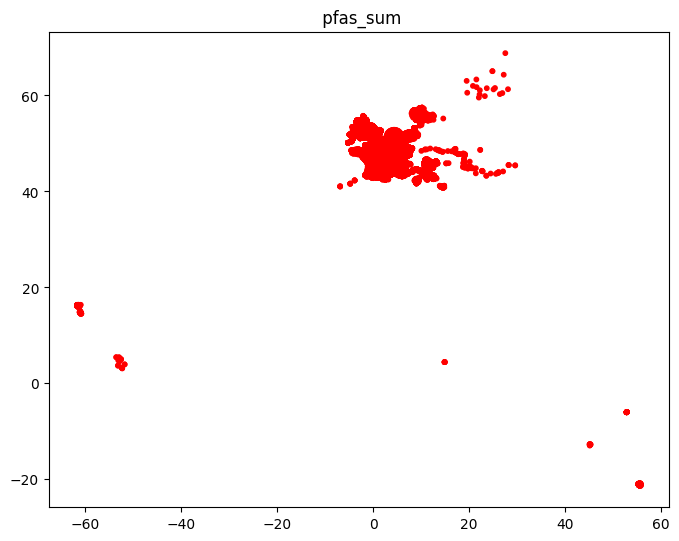

In [15]:
import gstlearn.plot as gp
fig, ax = gp.initGeographic()
ax.symbol(db, nameCoorX='lon', nameCoorY='lat')
plt.show()


In [26]:
print(db.getAllNames())

('lon', 'lat', 'pfas_sum')


In [27]:
dbfmt = gl.DbStringFormat.createFromFlags(flag_stats=True, names=['lon', 'lat', 'pfas_sum'])
db.display(dbfmt)


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 0
Number of Columns            = 3
Total number of samples      = 36650

Data Base Statistics
--------------------
1 - Name lon - Locator NA
 Nb of data          =      36650
 Nb of active values =      34956
 Minimum value       =    -61.761
 Maximum value       =     55.733
 Mean value          =      3.708
 Standard Deviation  =      7.329
 Variance            =     53.708
2 - Name lat - Locator NA
 Nb of data          =      36650
 Nb of active values =      34956
 Minimum value       =    -21.364
 Maximum value       =     68.793
 Mean value          =     48.017
 Standard Deviation  =      6.101
 Variance            =     37.226
3 - Name pfas_sum - Locator NA
 Nb of data          =      36650
 Nb of active values =      36650
 Minimum value       =      0.000
 Maximum value       = 30334400.000
 Mean value          =   9236.762
 Standard Dev

In [29]:
gl.dbStatisticsMono(db,
                     names=['lon', 'lat', 'pfas_sum'],
                     opers=gl.EStatOption.fromKeys(["MEAN","MINI","MAXI"]))

               Mean    Minimum    Maximum
     lon      3.708    -61.761     55.733
     lat     48.017    -21.364     68.793
pfas_sum   9626.103      0.000 30334400.000

In [30]:
db.toTL()

,lon,lat,pfas_sum
0,17.283800,48.029770,8.5
1,19.885714,45.258514,7.2
2,25.914750,43.881083,201.7
3,19.123680,47.728225,13.1
4,18.749972,45.866695,28.9
...,...,...,...
36645,6.853890,51.017100,0.0
36646,6.853890,51.017100,13.0
36647,7.029540,50.890190,0.0
36648,7.043190,50.880020,11.0


In [31]:
db.setLocators(["lon","lat"], gl.ELoc.X)
db.setLocator("pfas_sum", gl.ELoc.Z)
db


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 36650

Variables
---------
Column = 0 - Name = lon - Locator = x1
Column = 1 - Name = lat - Locator = x2
Column = 2 - Name = pfas_sum - Locator = z1